aaa

get the modules listed here + the modules needed to run them 

In [1]:
!pwd
from bumps.names import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.fft as fft
import molgroups as mol

/Users/alyssa/Documents/GitHub/molgroups/Diffraction/Python/Diffraction_fitting_fp


In [2]:
def getSLD(aArea, aSL, dimension, stepsize, normArea, bulknsld):
    aSLD = np.zeros(dimension).tolist()
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i]*stepsize) * aArea[i] / normArea + bulknsld * (1 - aArea[i]/normArea)
        else:
            aSLD[i] = bulknsld
    return aSLD

In [3]:
def computeFormFactor(lq, aSLD, dimension, stepsize, bulknsld, prefactor, dq):
    center = bilayer.fnGetCenter()
    center = center//stepsize
    canvas_center = dimension//2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1])*0.5
    symmetrized_bilayer -= bulknsld
    half_bilayer = symmetrized_bilayer[int(dimension/2):]

    # TODO: Make sure that lq and x are roughly comparable
    dct_dimension = 5000
    F = fft.dct(half_bilayer, n=dct_dimension)
    F = np.abs(F)
    x = np.array([np.pi/(2*dct_dimension*stepsize)*(2*i) + dq for i in range(int(dct_dimension))])

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, left=None, right=None, period=None)*prefactor

In [4]:
def setBilayer(startz, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma):
    bilayer.headgroup1.fnSet(hg_thickness, rel_pos)
    bilayer.headgroup2.fnSet(hg_thickness, rel_pos)
    bilayer.methyl_sigma = methyl_sigma
    bilayer.fnSet(sigma, bulknsld, startz, l_lipid, l_lipid, vf_bilayer=1)

In [5]:
def modelformfactor(lq, l_lipid, sigma, bulknsld, prefactor, dq, rel_pos, hg_thickness, methyl_sigma):
    setBilayer(startz, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma)
    normArea, aArea, aSL = bilayer.fnWriteProfile(np.zeros(dimension), np.zeros(dimension), dimension, stepsize, maxarea)
    aSLD = getSLD(aArea, aSL, dimension, stepsize, normArea, bulknsld)
    modelform = computeFormFactor(lq, aSLD, dimension, stepsize, bulknsld, prefactor, dq)
    return modelform

Global Variables

In [6]:
    maxarea = 100
    stepsize = 0.5
    dimension = 300
    startz = 50

Load Experimental Data

In [7]:
F2 = np.loadtxt("Experimental_form_factors/dopc.dat", skiprows=1)
F2 = np.abs(F2)
q_exp = F2[:,0]
form_exp = F2[:,1]
#constant error bar estimate of .05 Å
dform_exp = [0.05]*len(form_exp)

In [8]:
bilayer = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = 7.5978E-03, 4.6150E-03, 5.0652E-04, 972.00, 98, 331.00, 9.56
bilayer.fnInit(va1, na1, vm1, nm1, vh1, nh1, lh1)

In [9]:
l_lipid = 11.6
sigma = 2.0
bulknsld = 9.4114E-06
prefactor = 15000
dq = 0.
rel_pos = .5
methyl_sigma = 2

In [10]:
M1 = Curve(modelformfactor, q_exp, form_exp, dform_exp, l_lipid=l_lipid, sigma=sigma, bulknsld=bulknsld,
           prefactor=prefactor, dq=dq, rel_pos=rel_pos, hg_thickness=lh1, methyl_sigma=methyl_sigma)

In [11]:
M1.l_lipid.range(9, 13)
M1.sigma.range(1.0, 4.0)
M1.bulknsld.range(9e-6, 10e-6)
M1.prefactor.range(5000, 30000)
M1.dq.range(-0.02, 0.02)
M1.hg_thickness.range(8, 14)
M1.rel_pos.range(0, 1)
M1.methyl_sigma.range(0, 4)

Parameter(methyl_sigma)

In [12]:
model = M1
problem = FitProblem(model)

In [13]:
result = fit(problem, method='dream', samples=10, burn=10, steps=10, thin=1, alpha=0, outliers='none', trim = 'none')

# steps: 10, # draws: 800
Did not converge!


In [14]:
from bumps.dream.stats import var_stats, format_vars, save_vars
print("final chisq", problem.chisq_str())
draw = result.state.draw(portion=1)
all_vstats = var_stats(draw)
print(format_vars(all_vstats))

final chisq 3.608(11)
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1             bulknsld 9.419(33)e-6 0.000009411 0.000009881 [0.00000941 0.00000942] [0.00000941 0.00000951]
 2                   dq 0.04(20)e-3 0.000000 0.002803 [-0.00000 0.00003] [-0.00003 0.00069]
 3         hg_thickness  9.566(33)  9.5600  9.9673 [  9.560   9.566] [  9.551   9.639]
 4              l_lipid 11.599(16) 11.6000 11.3601 [ 11.599  11.602] [ 11.578  11.612]
 5         methyl_sigma  1.994(27)  2.0000  1.6283 [  1.997   2.000] [  1.920   2.002]
 6            prefactor 15000.6(51) 15000.01 15043.26 [14999.2 15001.8] [14992.5 15015.6]
 7              rel_pos  0.502(10)  0.5000  0.6417 [  0.500   0.502] [  0.500   0.529]
 8                sigma  1.998(20)  2.0000  1.6562 [  1.999   2.000] [  1.956   2.003]


In [30]:
import math
# Set space between plots in horiz and vert.
H_SPACE = 0.2
V_SPACE = 0.2

# Set top, bottom, left margins.
T_MARGIN = 0.2
B_MARGIN = 0.2
L_MARGIN = 0.2
R_MARGIN = 0.4

# Set desired plot sizes.
TILE_W = 3.0
TILE_H = 2.0
CBAR_WIDTH = 0.75


def var_plot_size(n):
    ncol, nrow = tile_axes_square(n)

    # Calculate total width and figure size
    plots_width = (TILE_W+H_SPACE)*ncol
    figwidth = plots_width + CBAR_WIDTH + L_MARGIN + R_MARGIN
    figheight = (TILE_H+V_SPACE)*nrow + T_MARGIN + B_MARGIN
    return figwidth, figheight

def _make_var_axes(n):
    """
    Build a figure with one axis per parameter,
    and one axis (the last one) to contain the colorbar.
    Use to make the vars histogram figure.
    """
    fig = plt.gcf()
    fig.clf()
    total_width, total_height = fig.get_size_inches()

    ncol, nrow = tile_axes_square(n)

    # Calculate dimensions as a faction of figure size.
    v_space_f = V_SPACE/total_height
    h_space_f = H_SPACE/total_width
    t_margin_f = T_MARGIN/total_height
    b_margin_f = B_MARGIN/total_height
    l_margin_f = L_MARGIN/total_width
    top = 1 - t_margin_f+v_space_f
    left = l_margin_f

    tile_h = (total_height - T_MARGIN - B_MARGIN)/nrow - V_SPACE
    tile_w = (total_width - L_MARGIN - R_MARGIN - CBAR_WIDTH)/ncol - H_SPACE
    tile_h_f = tile_h/total_height
    tile_w_f = tile_w/total_width

    # Calculate colorbar location (left, bottom) and colorbar height.
    l_cbar_f = l_margin_f + ncol*(tile_w_f+h_space_f)
    b_cbar_f = b_margin_f + v_space_f
    cbar_w_f = CBAR_WIDTH/total_width
    cbar_h_f = 1 - t_margin_f - b_margin_f - v_space_f
    cbar_box = [l_cbar_f, b_cbar_f, cbar_w_f, cbar_h_f]

    k = 0
    for j in range(1, nrow+1):
        for i in range(0, ncol):
            if k >= n:
                break
            dims = [left + i*(tile_w_f+h_space_f),
                    top - j*(tile_h_f+v_space_f),
                    tile_w_f,
                    tile_h_f]
            ax = fig.add_axes(dims)
            ax.set_facecolor('none')
            k += 1

    fig.add_axes(cbar_box)
    #fig.set_size_inches(total_width, total_height)
    return fig


def tile_axes_square(n):
    """
    Determine number of columns by finding the
    next greatest square, then determine number
    of rows needed.
    """
    cols = int(math.ceil(sqrt(n)))
    rows = int(math.ceil(n/float(cols)))
    return cols, rows


def plot_vars(draw, all_vstats, **kw):
    n = len(all_vstats)
    fig = _make_var_axes(n)
    cbar = _make_fig_colorbar(draw.logp)
    for k, vstats in enumerate(all_vstats):
        fig.sca(fig.axes[k])
        plot_var(draw, vstats, k, cbar, **kw)


def plot_var(draw, vstats, var, cbar, nbins=30):
    values = draw.points[:, var].flatten()
    _make_logp_histogram(values, draw.logp, nbins, vstats.p95_range,
                         draw.weights, cbar)
    _decorate_histogram(vstats)


def _decorate_histogram(vstats):
    import pylab
    from matplotlib.transforms import blended_transform_factory as blend

    l95, h95 = vstats.p95_range
    l68, h68 = vstats.p68_range

    # Shade things inside 1-sigma
    pylab.axvspan(l68, h68, color='gold', alpha=0.5, zorder=-1)
    # build transform with x=data, y=axes(0,1)
    ax = pylab.gca()
    transform = blend(ax.transData, ax.transAxes)

    def marker(symbol, position):
        if position < l95:
            symbol, position, ha = '<'+symbol, l95, 'left'
        elif position > h95:
            symbol, position, ha = '>'+symbol, h95, 'right'
        else:
            symbol, position, ha = symbol, position, 'center'
        pylab.text(position, 0.95, symbol, va='top', ha=ha,
                   transform=transform, zorder=3, color='g')
        #pylab.axvline(v)

    marker('|', vstats.median)
    marker('E', vstats.mean)
    marker('*', vstats.best)

    pylab.text(0.01, 0.95, vstats.label, zorder=2,
               backgroundcolor=(1, 1, 0, 0.2),
               verticalalignment='top',
               horizontalalignment='left',
               transform=pylab.gca().transAxes)
    ax.set_yticklabels([])


def _make_fig_colorbar(logp):
    import matplotlib as mpl
    import pylab

    # Option 1: min to min + 4
    #vmin=-max(logp); vmax=vmin+4
    # Option 1b: min to min log10(num samples)
    #vmin=-max(logp); vmax=vmin+log10(len(logp))
    # Option 2: full range of best 98%
    snllf = pylab.sort(-logp)
    vmin, vmax = snllf[0], snllf[int(0.98*(len(snllf)-1))]  # robust range
    # Option 3: full range
    #vmin,vmax = -max(logp),-min(logp)

    fig = pylab.gcf()
    ax = fig.axes[-1]
    cmap = mpl.cm.copper

    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    class MinDigitsFormatter(mpl.ticker.Formatter):
        def __init__(self, low, high):
            self.delta = high - low

        def __call__(self, x, pos=None):
            return format_value(x, self.delta)

    ticks = ()  #(vmin, vmax)
    formatter = MinDigitsFormatter(vmin, vmax)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,
                                   ticks=ticks, format=formatter,
                                   orientation='vertical')
    #cb.set_ticks(ticks)
    #cb.set_ticklabels(labels)
    #cb.set_label('negative log likelihood')

    cbar_box = ax.get_position().bounds
    fig.text(cbar_box[0],cbar_box[1],
             '{:.3G}'.format(vmin), va='top')
    fig.text(cbar_box[0], cbar_box[1]+cbar_box[3],
             '{:.3G}'.format(vmax), va='bottom')

    return vmin, vmax, cmap


def _make_logp_histogram(values, logp, nbins, ci, weights, cbar):
    from numpy import (ones_like, searchsorted, linspace, cumsum, diff,
                       argsort, array, hstack, exp)
    if weights is None:
        weights = ones_like(logp)
    # TODO: values are being sorted to collect stats and again to plot
    idx = argsort(values)
    values, weights, logp = values[idx], weights[idx], logp[idx]
    #open('/tmp/out','a').write("ci=%s, range=%s\n"
    #                           % (ci,(min(values),max(values))))
    edges = linspace(ci[0], ci[1], nbins+1)
    idx = searchsorted(values[1:-1], edges)
    weightsum = cumsum(weights)
    heights = diff(weightsum[idx])/weightsum[-1]  # normalized weights

    import pylab
    vmin, vmax, cmap = cbar
    cmap_steps = linspace(vmin, vmax, cmap.N+1)
    bins = []  # marginalized maximum likelihood
    for h, s, e, xlo, xhi \
            in zip(heights, idx[:-1], idx[1:], edges[:-1], edges[1:]):
        if s == e:
            continue
        pv = -logp[s:e]
        pidx = argsort(pv)
        pw = weights[s:e][pidx]
        x = array([xlo, xhi], 'd')
        y = hstack((0, cumsum(pw)))
        z = pv[pidx][:, None]
        # centerpoint, histogram height, maximum likelihood for each bin
        bins.append(((xlo+xhi)/2, y[-1], exp(vmin-z[0])))
        if len(z) > cmap.N:
            # downsample histogram bar according to number of colors
            pidx = searchsorted(z[1:-1].flatten(), cmap_steps)
            if pidx[-1] < len(z)-1:
                pidx = hstack((pidx, -1))
            y, z = y[pidx], z[pidx]
        pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap, shading='gouraud')
    # Check for broken distribution
    if not bins:
        return
    centers, height, maxlikelihood = array(bins).T
    # Normalize maximum likelihood plot so it contains the same area as the
    # histogram, unless it is really spikey, in which case make sure it has
    # about the same height as the histogram.
    maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
    hist_peak = np.max(height)
    ml_peak = np.max(maxlikelihood)
    if ml_peak > hist_peak*1.3:
        maxlikelihood *= hist_peak*1.3/ml_peak
    pylab.plot(centers, maxlikelihood, '-g')

    ## plot marginal gaussian approximation along with histogram
    #def G(x, mean, std):
    #    return np.exp(-((x-mean)/std)**2/2)/np.sqrt(2*np.pi*std**2)
    ## TODO: use weighted average for standard deviation
    #mean, std = np.average(values, weights=weights), np.std(values, ddof=1)
    #pdf = G(centers, mean, std)
    #pylab.plot(centers, pdf*np.sum(height)/np.sum(pdf), '-b')


def _make_var_histogram(values, logp, nbins, ci, weights):
    # Produce a histogram
    hist, bins = np.histogram(values, bins=nbins, range=ci,
                              #new=True,
                              density=True, weights=weights)

    # Find the max likelihood for values in each bin
    edges = np.searchsorted(values, bins)
    histbest = [np.max(logp[edges[i]:edges[i+1]])
                if edges[i] < edges[i+1] else -np.inf
                for i in range(nbins)]

    # scale to marginalized probability with peak the same height as hist
    histbest = np.exp(np.asarray(histbest) - max(logp)) * np.max(hist)

    import pylab
    # Plot the histogram
    pylab.bar(bins[:-1], hist, width=bins[1]-bins[0])

    # Plot the kernel density estimate
    #density = KDE1D(values)
    #x = linspace(bins[0],bins[-1],100)
    #pylab.plot(x, density(x), '-k')

    # Plot the marginal maximum likelihood
    centers = (bins[:-1]+bins[1:])/2
    pylab.plot(centers, histbest, '-g')

<ipython-input-30-32b0ac362196>:230: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
<ipython-input-30-32b0ac362196>:234: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers, height, maxlikelihood = array(bins).T
<ipython-input-30-32b0ac362196>:230: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass

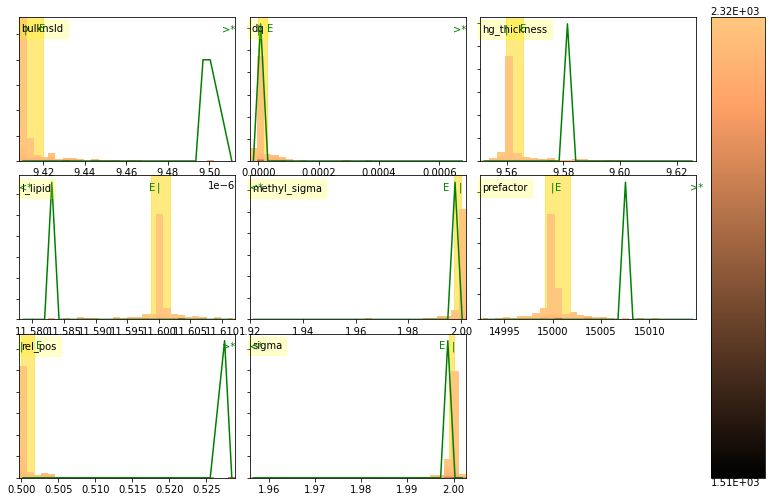

In [31]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig, suptitle, rcParams
figure(figsize=var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0]//10000, 400), 30)
plot_vars(draw, all_vstats, nbins=nbins)

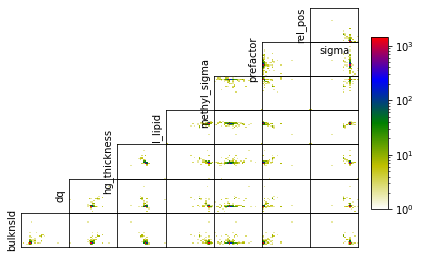

In [32]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()

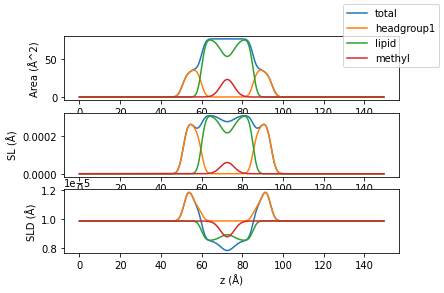

In [33]:
import plot
bulknsld, dq, hg_thickness, l_lipid, methyl_sigma, prefactor, rel_pos, sigma = result.x
setBilayer(50, l_lipid, sigma, bulknsld, rel_pos, hg_thickness, methyl_sigma)
plot.graphProfiles(bilayer, dimension, stepsize, maxarea, bulknsld, show=True, savefile=None)